In [1]:
import pickle as pkl
import yaml
import numpy as np
import matplotlib.pyplot as plt
import os
import fastText
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

In [2]:
global CFG
with open("../../config.yaml", "r") as ymlfile:
    CFG = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [3]:
rep_type = "ft"
model_type = "disc_spe"
bag_type = "cie"

In [4]:
res_path = os.path.join(CFG["datadir"], "OUTPUTS_" + model_type + "_" + bag_type + "_" + rep_type + "_avg_b4Training_bs64_TEST.pkl")
with open(res_path, "rb") as f:
    b4_training = pkl.load(f)

In [5]:
selected_people = range(0, len(b4_training["indices"]), 100)

In [6]:
if model_type == "disc_poly":
    cie_dico = [i for i in b4_training["cie"]]
    cie_outputs = np.array([b4_training["cie"][i][0] for i in cie_dico])
    clus_dico = [i for i in b4_training["clus"]]
    clus_outputs = np.array([b4_training["clus"][i][0] for i in clus_dico])
    dpt_dico = [i for i in b4_training["dpt"]]
    dpt_outputs = np.array([b4_training["dpt"][i][0] for i in dpt_dico])
else:
    dico = [i.cpu().numpy() for i in b4_training["preds"]]
    b4_outputs = np.array(dico)

In [6]:
description =  "disc_spe_cie_ft_avg_bagTransformer_bs64_TEST"
tgt_file = os.path.join(CFG["datadir"], "OUTPUTS_" + description + ".pkl")
with open(tgt_file, 'rb') as f:
    model_outputs = pkl.load(f)
# trained_outputs = np.argmax(outputs["cie"]["preds"].cpu().numpy(), axis=-1)
trained_outputs = model_outputs["preds"].detach().cpu().numpy()

Text(0.5, 1.0, '1-hot affinity score for Companies -  after training')

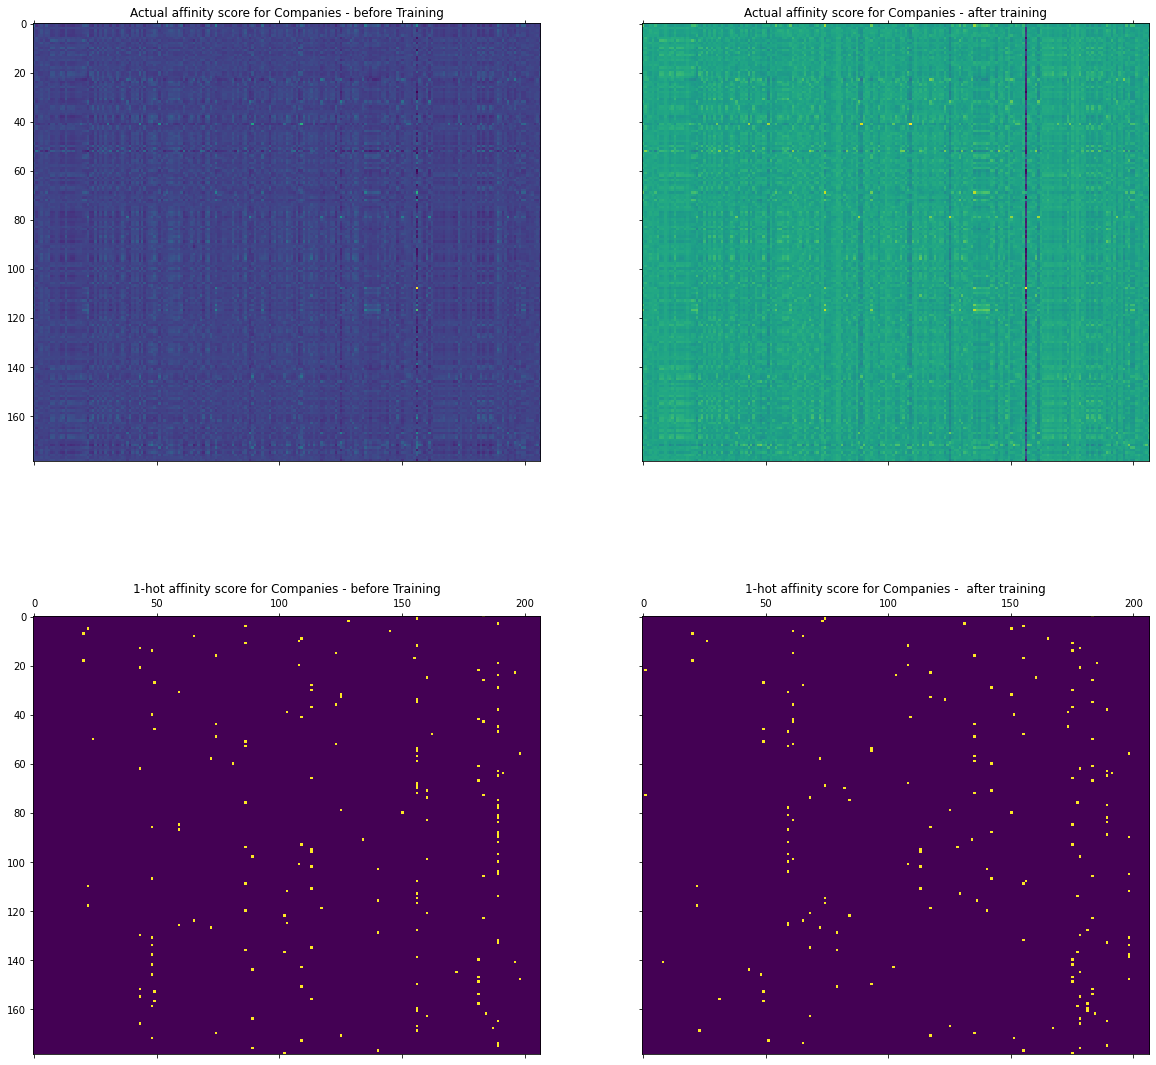

In [8]:
tmp = np.argmax(trained_outputs, axis=-1)
one_hot_trained_outputs = np.zeros((len(trained_outputs), 207))
for i, j in enumerate(tmp):
    one_hot_trained_outputs[i][j] = 1.
tmp = np.argmax(b4_outputs, axis=-1)
one_hot_b4_outputs = np.zeros((len(b4_outputs), 207))
for i, j in enumerate(tmp):
    one_hot_b4_outputs[i][j] = 1.

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2, 2,sharex = True,sharey=True, figsize=(20, 20))
plot1 = ax1.matshow(normalize(b4_outputs[selected_people]))
#fig.colorbar(plot1, cax=ax1)
ax1.set_title('Actual affinity score for Companies - before Training')

plot2 = ax2.matshow(normalize(trained_outputs[selected_people]))
#fig.colorbar(plot2, cax=ax2)
ax2.set_title('Actual affinity score for Companies - after training')

plot3 = ax3.matshow(normalize(one_hot_b4_outputs[selected_people]))
#fig.colorbar(plot3, cax=ax3)
ax3.set_title('1-hot affinity score for Companies - before Training')

plot4 = ax4.matshow(normalize(one_hot_trained_outputs[selected_people]))
#plt.colorbar(plot4, cax=ax4)
ax4.set_title('1-hot affinity score for Companies -  after training')

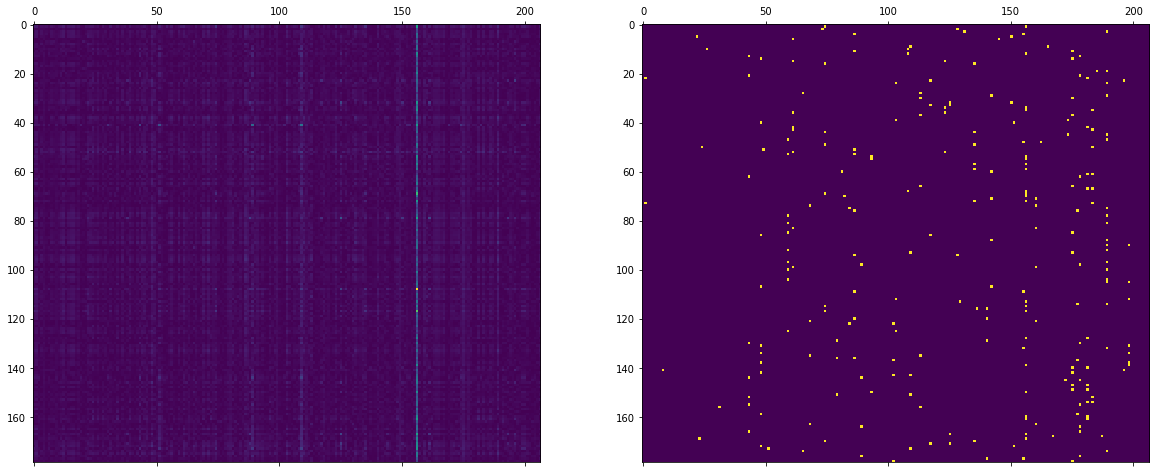

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
cax = ax[0].matshow(abs(normalize(b4_outputs[selected_people]) - normalize(trained_outputs[selected_people])))
ax[1].matshow(abs(normalize(one_hot_b4_outputs[selected_people]) - normalize(one_hot_trained_outputs[selected_people]) ) )


In [7]:
wc_file = os.path.join(CFG["datadir"], "OUTPUTS_well_classified_" + description)
with open(wc_file + ".pkl", 'rb') as f:
    wc_test = pkl.load(f)
lookup_file = os.path.join(CFG["datadir"], "profiles_jobs_skills_TEST.pkl")
with open(lookup_file, 'rb') as f:
    all_people = pkl.load(f)

In [19]:
ft_model = fastText.load_model(os.path.join(CFG["modeldir"], "ft_fs.bin")) 

In [9]:
lookup = {}
for person in tqdm(all_people):
    lookup[person[0]] = {"skills" : person[1],
                        "industry": person[2],
                        "jobs": person[3]}

100%|██████████| 27040/27040 [00:00<00:00, 713335.85it/s]


In [14]:
indices_to_pred_and_labels = {}
for num, index in enumerate(model_outputs["indices"]):
    if index in wc_test["indices"]:
        indices_to_pred_and_labels[index] = {"pred" : model_outputs["preds"][num].detach().numpy(),
                                             'label': model_outputs["labels"][num].item()}
selected_people = {}
for index in wc_test["indices"]:
    selected_people[index] = {**lookup[index], **indices_to_pred_and_labels[index]}

tensor(2)

In [40]:
jobs_and_emb = {}
for person in tqdm(selected_people.keys()):
    jobs_and_emb[person] = selected_people[person]
    jobs_and_emb[person]["job_emb"] = []
    for job in selected_people[person]["jobs"]:
        job_emb = np.zeros(300)
        for word in job["job"]:
            job_emb = np.concatenate((job_emb, ft_model.get_word_vector(word)), axis=-1)
        jobs_and_emb[person]["job_emb"].append(np.mean(np.reshape(job_emb, (-1, 300))[1:], axis=0))

100%|██████████| 17832/17832 [01:55<00:00, 154.69it/s]


In [41]:
import torch
del ft_model
file = os.path.join(CFG["datadir"],"jobs_and_emb_wc_"+ bag_type +"_" +  rep_type +"_TEST.pkl")
with open(file, "wb") as f:
    torch.save(jobs_and_emb, f)

In [29]:
job_emb = np.concatenate((job_emb, ft_model.get_word_vector(word)), axis=-1)

In [39]:
np.mean(np.reshape(job_emb, (-1, 300))[1:], axis=0).size

300

In [ ]:
# tmp = np.argmax(trained_outputs, axis=-1)
# one_hot_trained_outputs = np.zeros((len(trained_outputs), 207))
# for i, j in enumerate(tmp):
#     one_hot_trained_outputs[i][j] = 1.
# tmp = np.argmax(b4_outputs, axis=-1)
# one_hot_b4_outputs = np.zeros((len(b4_outputs), 207))
# for i, j in enumerate(tmp):
#     one_hot_b4_outputs[i][j] = 1.
# fig, ax = plt.subplots(2, 2, figsize=(20, 20))
# ax[0][0].matshow(normalize(b4_outputs[:200]))
# ax[0][0].set_title('Actual affinity score for Companies - before Training')
# ax[0][1].matshow(normalize(one_hot_b4_outputs[:200]))
# ax[0][1].set_title('1-hot affinity score for Companies - before Training')
# ax[1][0].matshow(normalize(trained_outputs[:200]))
# ax[1][0].set_title('Actual affinity score for Companies - after training')
# ax[1][1].matshow(normalize(one_hot_trained_outputs[:200]))
# ax[1][1].set_title('1-hot affinity score for Companies -  after training')


#np.random.shuffle(cie_outputs)
# tmp = np.argmax(cie_outputs, axis=-1)
# one_hot_cie_outputs = np.zeros((len(cie_outputs), 207))
# for i, j in enumerate(tmp):
#     one_hot_cie_outputs[i][j] = 1.
# fig, ax = plt.subplots(1, 2, figsize=(20, 20))
# ax[0].matshow(normalize(cie_outputs[:100]))
# ax[0].set_title('Actual affinity score for Companies')
# ax[1].matshow(normalize(one_hot_cie_outputs[:100]))
# ax[1].set_title('1-hot affinity score for Companies')

# np.random.shuffle(clus_outputs)
# tmp = np.argmax(clus_outputs, axis=-1)
# one_hot_clus_outputs = np.zeros((len(clus_outputs), 30))
# for i, j in enumerate(tmp):
#     one_hot_clus_outputs[i][j] = 1.
# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].matshow(normalize(clus_outputs[:100]))
# ax[0].set_title('Actual affinity score for clusters')
# ax[1].matshow(normalize(one_hot_clus_outputs[:100]))
# ax[1].set_title('1-hot affinity score for clusters')


# np.random.shuffle(dpt_outputs)
# tmp = np.argmax(dpt_outputs, axis=-1)
# one_hot_dpt_outputs = np.zeros((len(dpt_outputs), 5888))
# for i, j in enumerate(tmp):
#     one_hot_dpt_outputs[i][j] = 1.
# fig, ax = plt.subplots(1, 2)
# ax[0].matshow(normalize(dpt_outputs[:][:10]))
# ax[0].set_title('Actual affinity score for departments')
# ax[1].matshow(normalize(one_hot_dpt_outputs[:][:10]))
# ax[1].set_title('1-hot affinity score for departments')